# Task 1 - CNN Model

---
## Import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, losses, Input
from keras_tuner import HyperParameters, RandomSearch, Objective
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

from utils.tensorflow_preprocessing import prepare_image_target_dataset

In [2]:
%store -r train_X
%store -r val_X
%store -r test_X

---
## Prepare dataset

In [3]:
# TODO: REMOVE
frac = 0.01
train_X = train_X.sample(frac=frac, random_state=42)
val_X = val_X.sample(frac=frac, random_state=42)
test_X = test_X.sample(frac=frac, random_state=42)

In [4]:
train_class_ds, class_encoder = prepare_image_target_dataset(train_X, target_name="Class")
val_class_ds, _ = prepare_image_target_dataset(val_X, target_name="Class", label_encoder=class_encoder)
test_class_ds, _ = prepare_image_target_dataset(test_X, target_name="Class", label_encoder=class_encoder)

In [5]:
print(type(class_encoder))

<class 'sklearn.preprocessing._label.LabelEncoder'>


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_class_ds = train_class_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_class_ds = val_class_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_class_ds = test_class_ds.cache().prefetch(buffer_size=AUTOTUNE)

---
## Model training

In [7]:
# Basic Model Training
def create_model():
    model = models.Sequential([
        Input(shape=(256, 256, 3)),
        layers.Conv2D(4, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (4, 4), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (4, 4), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5, seed=21),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5, seed=42),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(6, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model


In [8]:
# Train the model
model = create_model()
epochs = 10
history = model.fit(train_class_ds, epochs=epochs, batch_size=32, validation_data=test_class_ds)

Epoch 1/10
17/17 [==============================] - 3s 158ms/step - loss: 1.7634 - accuracy: 0.2222 - val_loss: 1.5955 - val_accuracy: 0.2278
Epoch 2/10
17/17 [==============================] - 2s 142ms/step - loss: 1.5815 - accuracy: 0.3130 - val_loss: 1.5712 - val_accuracy: 0.3556
Epoch 3/10
17/17 [==============================] - 2s 137ms/step - loss: 1.5700 - accuracy: 0.2741 - val_loss: 1.5675 - val_accuracy: 0.3556
Epoch 4/10
17/17 [==============================] - 2s 144ms/step - loss: 1.5555 - accuracy: 0.3370 - val_loss: 1.5525 - val_accuracy: 0.3556
Epoch 5/10
17/17 [==============================] - 2s 143ms/step - loss: 1.5446 - accuracy: 0.3389 - val_loss: 1.5554 - val_accuracy: 0.3556
Epoch 6/10
17/17 [==============================] - 2s 134ms/step - loss: 1.5212 - accuracy: 0.3537 - val_loss: 1.5368 - val_accuracy: 0.3556
Epoch 7/10
17/17 [==============================] - 2s 131ms/step - loss: 1.5169 - accuracy: 0.3241 - val_loss: 1.5379 - val_accuracy: 0.3556
Epoch 

In [9]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_class_ds)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

6/6 [==============================] - 0s 35ms/step - loss: 1.4517 - accuracy: 0.3722
Test Loss: 1.4517
Test Accuracy: 0.3722


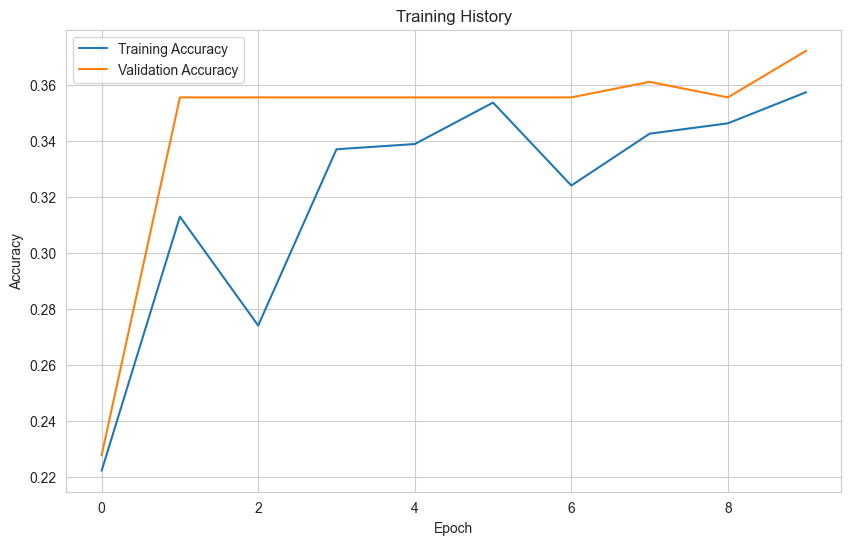

In [10]:
# Visualize the training history of the basic model
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training History')
    plt.show()

plot_training_history(history)

---
## Optimization

In [11]:
# Hyperparameter Tuning
def build_model(hp):
    model = models.Sequential([
        Input(shape=(256, 256, 3)),
        layers.Conv2D(4, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (4, 4), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (4, 4), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(hp.Choice('dense1_units', [64, 128]), activation='relu'),
        layers.Dropout(hp.Choice('dropout1_rate', [0.3, 0.5])),
        layers.Dense(hp.Choice('dense2_units', [64, 128]), activation='relu'),
        layers.Dropout(hp.Choice('dropout2_rate', [0.3, 0.5])),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(6, activation='softmax')
    ])

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

In [12]:
tuner = RandomSearch(
    build_model,
    objective=Objective('val_accuracy', direction='max'),
    max_trials=4,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='basic_tuning'
)

Reloading Tuner from tuner_results/basic_tuning/tuner0.json


In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dense1_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dropout1_rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.5], 'ordered': True}
dense2_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dropout2_rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.5], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}


In [14]:
tuner.search(train_class_ds,
             epochs=5,
             validation_data=val_class_ds)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [15]:
# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_class_ds)
print(f'Best Model Test Loss: {test_loss:.4f}')
print(f'Best Model Test Accuracy: {test_accuracy:.4f}')

6/6 [==============================] - 0s 36ms/step - loss: 0.8748 - accuracy: 0.6333
Best Model Test Loss: 0.8748
Best Model Test Accuracy: 0.6333


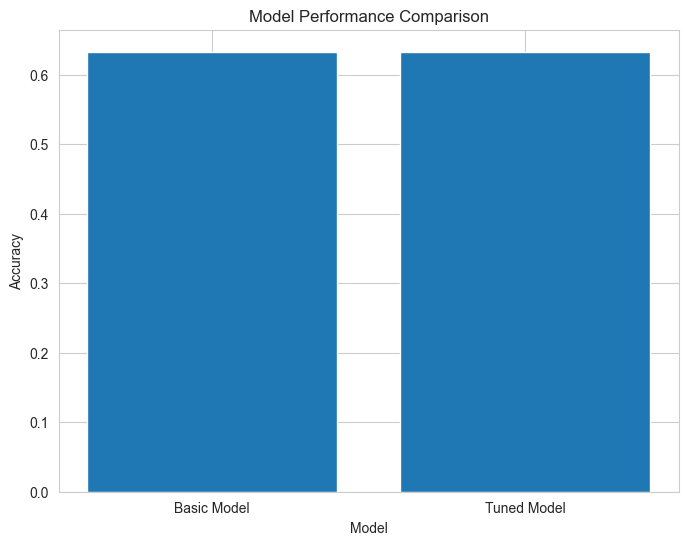

1/1 [==============================] - 0s 38ms/step


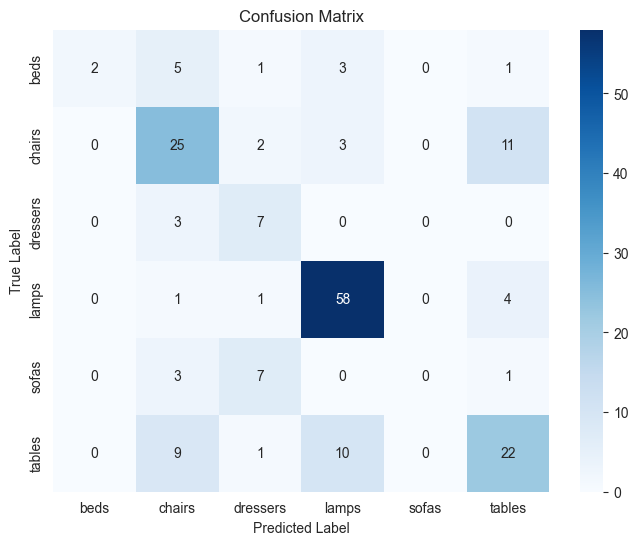

In [27]:
# Compare the performance of the basic model and the best model
models = ['Basic Model', 'Tuned Model']
accuracies = [test_accuracy, test_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()

# Visualize the confusion matrix
def plot_confusion_matrix(model, test_data, label_encoder):
    y_true = []
    y_pred = []
    for images, labels in test_data:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    cm = confusion_matrix(y_true, y_pred)

    # Get the decoded class labels
    class_labels = label_encoder.inverse_transform(np.unique(y_true))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(best_model, test_class_ds,class_encoder)

---
## Testing

1/1 [==============================] - 0s 72ms/step


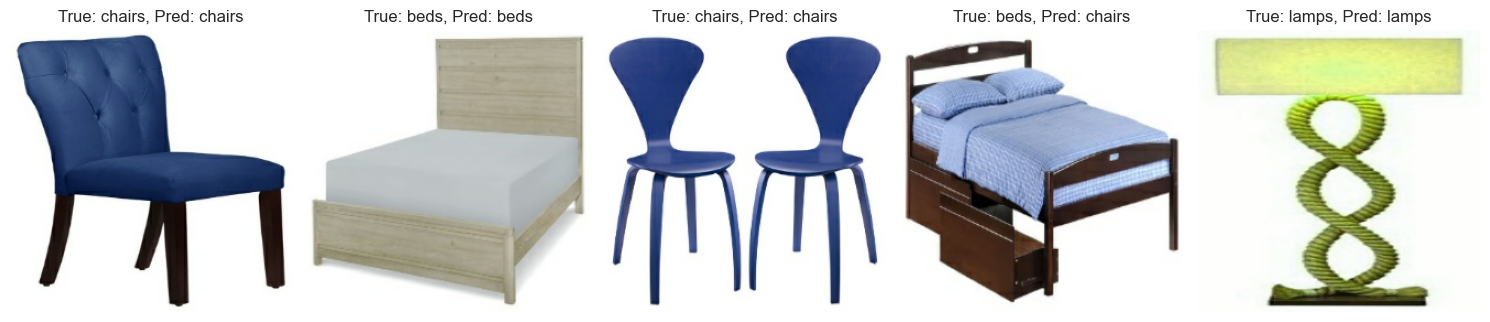

In [29]:
def visualize_predictions(model, test_data, label_encoder, num_samples=5):
    for images, labels in test_data.take(1):
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)

        plt.figure(figsize=(15, 12))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow((images[i].numpy() * 255).astype('uint8'))
            true_label = label_encoder.inverse_transform([labels[i]])[0]
            pred_label = label_encoder.inverse_transform([predicted_labels[i]])[0]
            plt.title(f"True: {true_label}, Pred: {pred_label}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

visualize_predictions(best_model, test_class_ds, class_encoder)

---
## Save model

In [30]:
from pathlib import Path

# Create paths
path = '../data/models'
processed_model_dir = Path(path)
processed_model_dir.mkdir(parents=True, exist_ok=True)

best_model.save(path + '/' + 'task-1-CNN.keras')